In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-306a879839c2>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


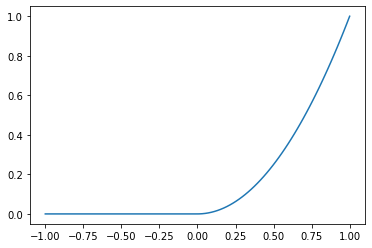

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)**2

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [5]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff, realistic_validation=True, init_xyz=[0.5,0.5,1.0], init_xy_span=[0.1,0.1], area_cost_func=area_cost, device=DEVICE),
                                             DetectorPanel(res=init_res, eff=init_eff, realistic_validation=True, init_xyz=[0.5,0.5,0.95], init_xy_span=[0.1,0.1], area_cost_func=area_cost, device=DEVICE),
                                             DetectorPanel(res=init_res, eff=init_eff, realistic_validation=True, init_xyz=[0.5,0.5,0.8], init_xy_span=[0.1,0.1], area_cost_func=area_cost, device=DEVICE),
                                             DetectorPanel(res=init_res, eff=init_eff, realistic_validation=True, init_xyz=[0.5,0.5,0.85], init_xy_span=[0.1,0.1], area_cost_func=area_cost, device=DEVICE),]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff, realistic_validation=True, init_xyz=[0.5,0.5,0.2], init_xy_span=[0.1,0.1], area_cost_func=area_cost, device=DEVICE),
                                             DetectorPanel(res=init_res, eff=init_eff, realistic_validation=True, init_xyz=[0.5,0.5,0.1], init_xy_span=[0.1,0.1], area_cost_func=area_cost, device=DEVICE),
                                             DetectorPanel(res=init_res, eff=init_eff, realistic_validation=True, init_xyz=[0.5,0.5,0.15], init_xy_span=[0.1,0.1], area_cost_func=area_cost, device=DEVICE),
                                             DetectorPanel(res=init_res, eff=init_eff, realistic_validation=True, init_xyz=[0.5,0.5,0.05], init_xy_span=[0.1,0.1], area_cost_func=area_cost, device=DEVICE),]))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.1000, 0.1000])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.1000, 0.1000])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8000]), and xy span tensor([0.1000, 0.1000])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([0.1000, 0.1000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.500

In [8]:
volume.load_rad_length(arb_rad_length)

In [9]:
volume.get_cost()

tensor(0.0008, grad_fn=<AddBackward0>)

In [10]:
muons = MuonBatch(generate_batch(100), 1, device=DEVICE)

In [11]:
muons.x = 0.125
muons.y = 0.125
muons.theta_x = 0.1
muons.theta_y = 0.1

In [12]:
volume.eval()

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.1000, 0.1000])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.1000, 0.1000])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8000]), and xy span tensor([0.1000, 0.1000])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([0.1000, 0.1000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.500

In [13]:
volume(muons)

In [14]:
muons.x

tensor([0.2259, 0.2223, 0.2313, 0.2266, 0.2274, 0.2212, 0.2259, 0.2264, 0.2305,
        0.2230, 0.2231, 0.2253, 0.2227, 0.2261, 0.2229, 0.2271, 0.2230, 0.2243,
        0.2282, 0.2276, 0.2247, 0.2254, 0.2252, 0.2239, 0.2256, 0.2282, 0.2237,
        0.2247, 0.2251, 0.2243, 0.2241, 0.2228, 0.2253, 0.2256, 0.2278, 0.2279,
        0.2254, 0.2274, 0.2226, 0.2303, 0.2239, 0.2253, 0.2261, 0.2241, 0.2247,
        0.2282, 0.2257, 0.2247, 0.2257, 0.2256, 0.2262, 0.2241, 0.2271, 0.2253,
        0.2229, 0.2240, 0.2243, 0.2216, 0.2259, 0.2263, 0.2239, 0.2237, 0.2242,
        0.2252, 0.2251, 0.2217, 0.2213, 0.2284, 0.2268, 0.2247, 0.2244, 0.2249,
        0.2260, 0.2262, 0.2238, 0.2258, 0.2252, 0.2293, 0.2272, 0.2247, 0.2263,
        0.2214, 0.2246, 0.2250, 0.2260, 0.2298, 0.2257, 0.2206, 0.2232, 0.2268,
        0.2280, 0.2248, 0.2258, 0.2279, 0.2283, 0.2243, 0.2250, 0.2263, 0.2206,
        0.2274])

In [15]:
muons.y

tensor([0.2248, 0.2232, 0.2242, 0.2236, 0.2243, 0.2249, 0.2249, 0.2251, 0.2242,
        0.2242, 0.2284, 0.2291, 0.2245, 0.2257, 0.2250, 0.2264, 0.2245, 0.2249,
        0.2256, 0.2222, 0.2270, 0.2258, 0.2282, 0.2243, 0.2241, 0.2260, 0.2267,
        0.2242, 0.2240, 0.2297, 0.2247, 0.2272, 0.2256, 0.2275, 0.2245, 0.2292,
        0.2243, 0.2267, 0.2272, 0.2242, 0.2261, 0.2236, 0.2256, 0.2215, 0.2232,
        0.2252, 0.2253, 0.2238, 0.2256, 0.2280, 0.2271, 0.2254, 0.2253, 0.2284,
        0.2250, 0.2243, 0.2229, 0.2259, 0.2248, 0.2265, 0.2254, 0.2242, 0.2264,
        0.2263, 0.2258, 0.2293, 0.2256, 0.2240, 0.2258, 0.2221, 0.2273, 0.2259,
        0.2271, 0.2294, 0.2200, 0.2277, 0.2226, 0.2262, 0.2272, 0.2256, 0.2265,
        0.2219, 0.2278, 0.2209, 0.2254, 0.2277, 0.2263, 0.2294, 0.2255, 0.2230,
        0.2266, 0.2273, 0.2248, 0.2267, 0.2270, 0.2205, 0.2273, 0.2248, 0.2248,
        0.2207])

In [16]:
sb = PanelScatterBatch(muons, volume)

In [17]:
mask = sb.get_scatter_mask()

In [18]:
mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [19]:
sb.location

tensor([[nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan],


In [20]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=0),
                             z_pos_opt=partial(torch.optim.SGD, lr=0),
                             xy_span_opt=partial(torch.optim.SGD, lr=0),
                             loss_func=DetectorLoss(target_budget=0.8, cost_coef=None))  # Loss is precision + cost_coef*detector cost, balance coef as required or leave as None to automatically balance on first batch

In [21]:
passives = PassiveYielder([arb_rad_length])

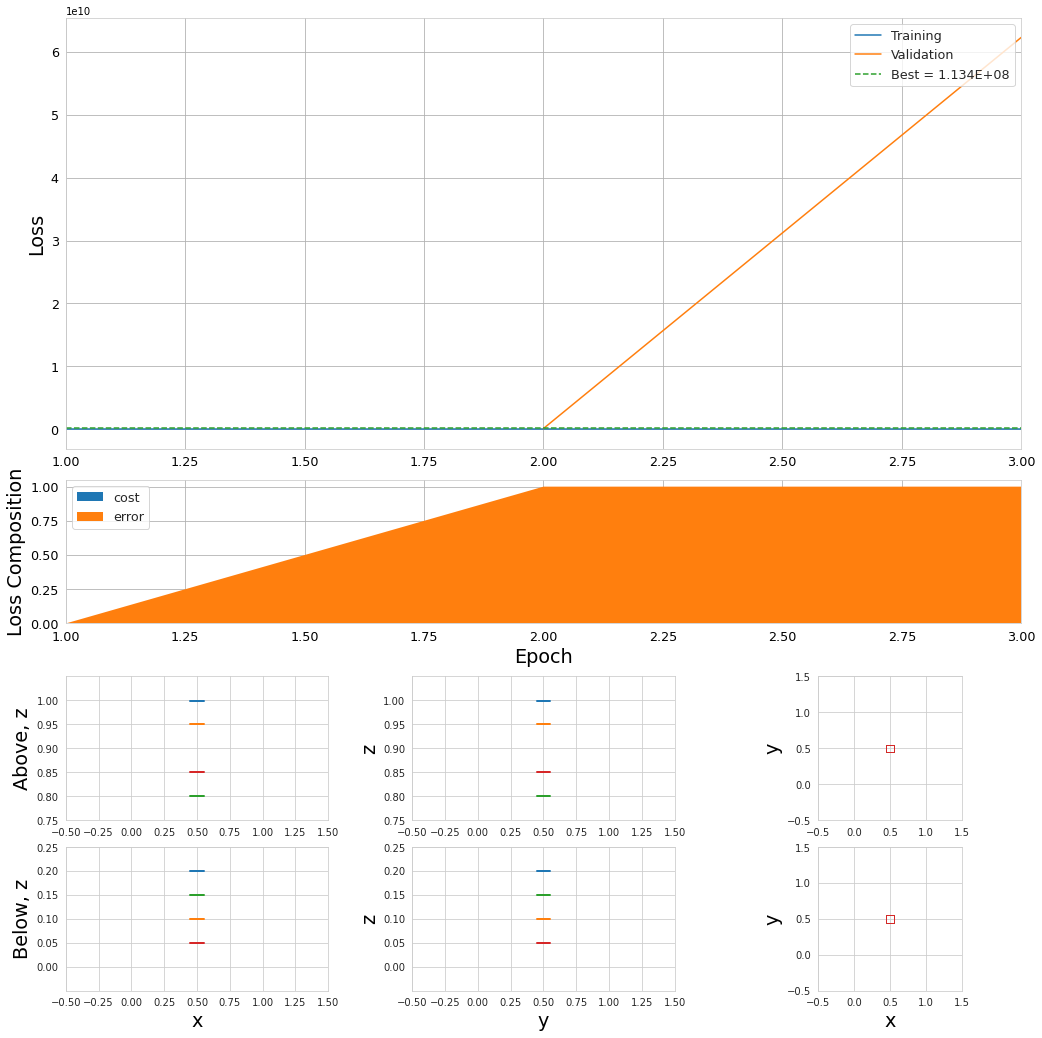

Automatically setting cost coefficient to 835.0010986328125


/home/centos/volume/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.,

ValueError: Weight contains values at zero

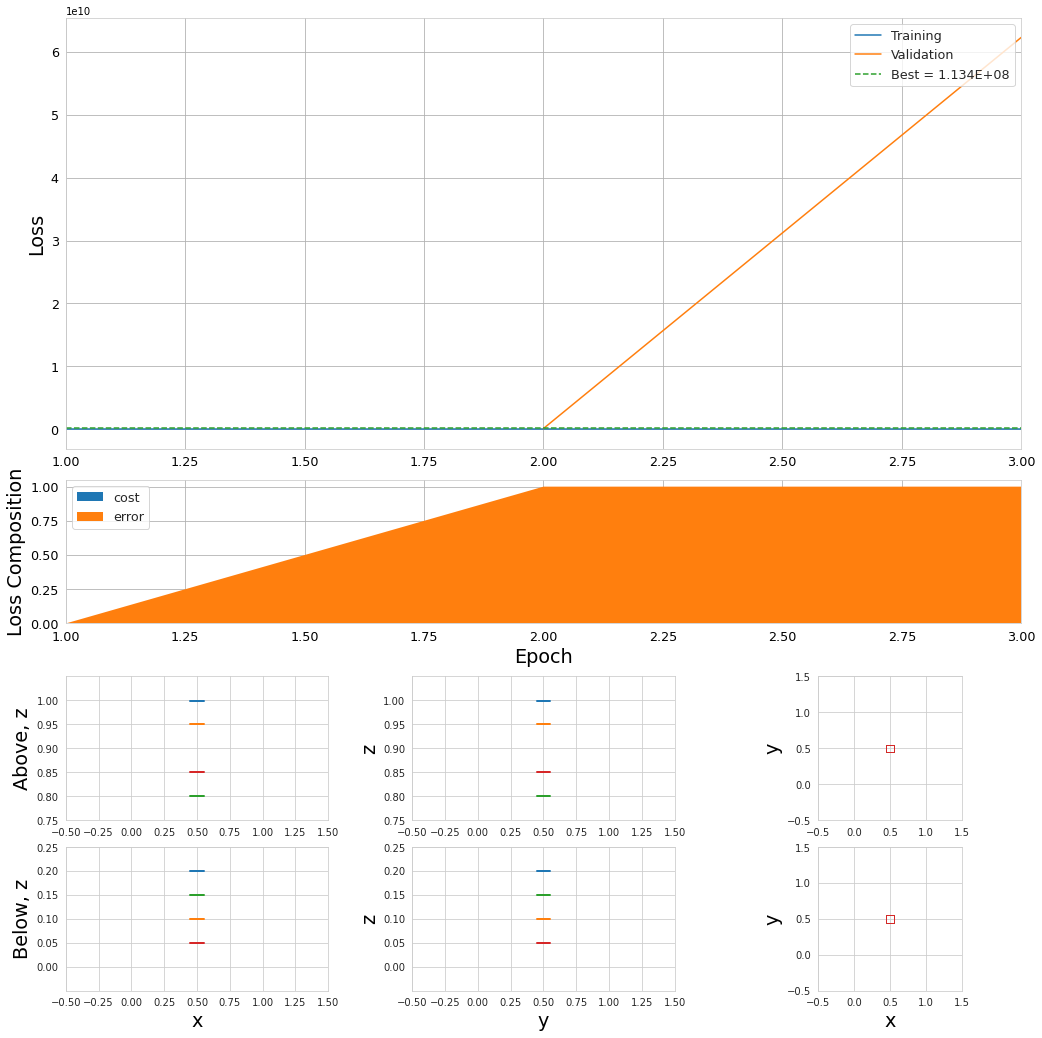

In [22]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[PanelMetricLogger()])

In [ ]:
for p in volume.parameters(): print(p)